In [1]:
# ref: 

# https://alexioannides.com/2018/11/07/bayesian-regression-in-pymc3-using-mcmc-variational-inference/
# https://docs.pymc.io/notebooks/bayesian_neural_network_advi.html

# http://stronginference.com/pymc3-release.html
# https://docs.pymc.io/notebooks/getting_started.html

# https://towardsdatascience.com/hands-on-bayesian-statistics-with-python-pymc3-arviz-499db9a59501

About NUTS [a self tuning form of HMC]
http://stronginference.com/pymc3-release.html
    
Though the version 2 and version 3 models are superficially similar (by design), there are very different things happening underneath when sampleis called in either case. By default, the PyMC3 model will use a form of gradient-based MCMC sampling, a self-tuning form of Hamiltonian Monte Carlo, called NUTS. Gradient based methods serve to drastically improve the efficiency of MCMC, without the need for running long chains and dropping large portions of the chains due to lack of convergence. Rather than conditionally sampling each model parameter in turn, the NUTS algorithm walks in k-space (where k is the number of model parameters), simultaneously updating all the parameters as it leap-frogs through the parameter space. Models of moderate complexity and size that would normally require 50,000 to 100,000 iterations now typically require only 2000-3000.

Unless specified otherwise, PyMC3 will assign the NUTS sampler to all the variables of the model. This happens here because our model contains only continuous random variables; NUTS will not work with discrete variables because it is impossible to obtain gradient information from them. Discrete variables are assigned the Metropolissampling algorithm (step method, in PyMC parlance). The next thing that happens is that the variables' initial values are assigned using Automatic Differentiation Variational Inference (ADVI). This is an approximate Bayesian inference algorithm that we have added to PyMC — more on that later. Though it can be used for inference in its own right, here we are using it merely to find good starting values for NUTS (in practice, this is important for getting NUTS to run well). Its an excessive step for small models like this, but it is the default behavior, designed to try and guarantee a good MCMC run.

In [2]:
%matplotlib inline
import theano
floatX = theano.config.floatX
import pymc3 as pm
import theano.tensor as T
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')
np.random.seed(23)

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


No handles with labels found to put in legend.


Loading (94, 1) (94, 1)


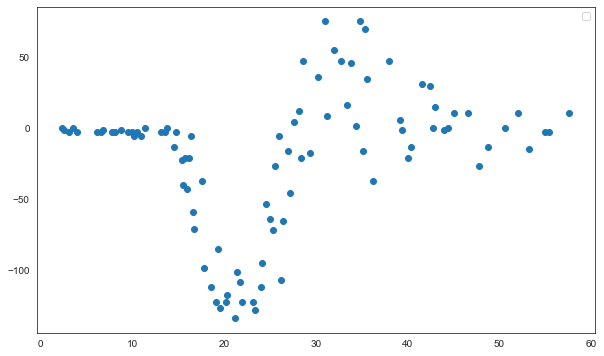

In [3]:
# Loading dataset

data = np.loadtxt('motor.dat')

X_data = data[:, 0][:, None]
y_data = data[:, 1][:, None]

print ('Loading',np.shape(X_data),np.shape(y_data))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.scatter(X_data,y_data)
ax.legend()
plt.show()

In [4]:
# Shuffling dataset

from sklearn.utils import shuffle

X_data_shuff,y_data_shuff = shuffle(X_data,y_data,random_state=23)
print ('Shuffling',np.shape(X_data_shuff),np.shape(y_data_shuff))

Shuffling (94, 1) (94, 1)


In [5]:
# Splitting dataset

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data_shuff, y_data_shuff, test_size=0.2, random_state=23)
print ('Splitting',np.shape(X_train), np.shape(y_train))
print ('Splitting',np.shape(X_test), np.shape(y_test))

Splitting (75, 1) (75, 1)
Splitting (19, 1) (19, 1)


Scaling (75, 1) (75, 1)
Scaling (19, 1) (19, 1)
Scaled(train+test) (94, 1) (94, 1)


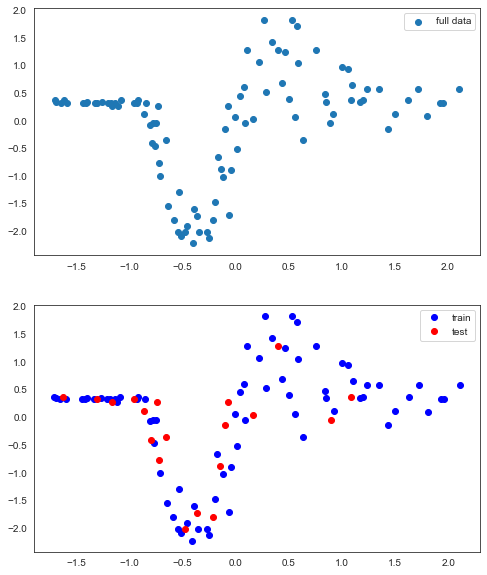

In [6]:
# Scaling dataset

from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
scaler_X.fit(X_train)
X_train = scaler_X.transform(X_train)
X_test = scaler_X.transform(X_test)

scaler_y = StandardScaler()
scaler_y.fit(y_train)
y_train = scaler_y.transform(y_train)
y_test = scaler_y.transform(y_test)

print ('Scaling',np.shape(X_train), np.shape(y_train))
print ('Scaling',np.shape(X_test), np.shape(y_test))

#combined data
X_data=np.vstack((X_train,X_test))
y_data=np.vstack((y_train,y_test))

print ('Scaled(train+test)',np.shape(X_data),np.shape(y_data))

fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(211)
ax1.scatter(X_data,y_data,label='full data')
ax1.legend()

ax2 = fig.add_subplot(212)
ax2.plot(X_train,y_train,'bo',label='train')
ax2.plot(X_test,y_test,'ro',label='test')
ax2.legend()
plt.show()

In [7]:
# Building pymc model

n_hidden = 10

# Initialize random weights between each layer
init_w_1 = np.random.randn(X_train.shape[1], n_hidden).astype(floatX)
init_w_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
init_w_out = np.random.randn(n_hidden,1).astype(floatX)

init_b_1 = np.random.randn(n_hidden).astype(floatX)
init_b_2 = np.random.randn(n_hidden).astype(floatX)
init_b_out = np.random.randn(1).astype(floatX)


def DNN(x_tensor, weights_in_1, bias_in_1, weights_1_2, bias_1_2, weights_2_out, bias_2_out):
    act_1 = pm.math.tanh(pm.math.dot(x_tensor,weights_in_1)+bias_in_1)
    act_2 = pm.math.tanh(pm.math.dot(act_1,weights_1_2)+bias_1_2)
    act_out = pm.math.dot(act_2,weights_2_out)+bias_2_out
    return act_out

with pm.Model() as neural_network:
    # Trick: Turning inputs and outputs into shared variables 
    # It's still the same thing, but we can later change the values of the shared variable
    # (to switch in the test-data later) and pymc3 will just use the new data.
    # Kind-of like a pointer we can redirect.
    # For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
    y_tensor = theano.shared(y_train)
    x_tensor = theano.shared(X_train)

    #PRIOR
    # Weights and biases from input to hidden layer
    weights_in_1 = pm.Normal('w_in_1', 0, sigma=1,
                             shape=(X_train.shape[1], n_hidden),
                             testval=init_w_1)
    
    bias_in_1 = pm.Normal('b_in_1', 0, sigma=1,
                             shape=(n_hidden),
                             testval=init_b_1)

    # Weights and biases from 1st to 2nd layer
    weights_1_2 = pm.Normal('w_1_2', 0, sigma=1,
                            shape=(n_hidden, n_hidden),
                            testval=init_w_2)
  
    bias_1_2 = pm.Normal('b_1_2', 0, sigma=1,
                             shape=(n_hidden),
                             testval=init_b_2)

    # Weights and biases from hidden layer to output
    weights_2_out = pm.Normal('w_2_out', 0, sigma=1,
                              shape=(n_hidden,1),
                              testval=init_w_out)

    bias_2_out = pm.Normal('b_2_out', 0, sigma=1,
                             shape=(1),
                             testval=init_b_out)
        
    # Build neural-network using activation function
    act_out = DNN(x_tensor, weights_in_1, bias_in_1, weights_1_2, bias_1_2, weights_2_out, bias_2_out)

    # LIKELIHOOD
    out = pm.Normal('out', mu=act_out, sigma=0.1, observed=y_tensor)


(5, 94)


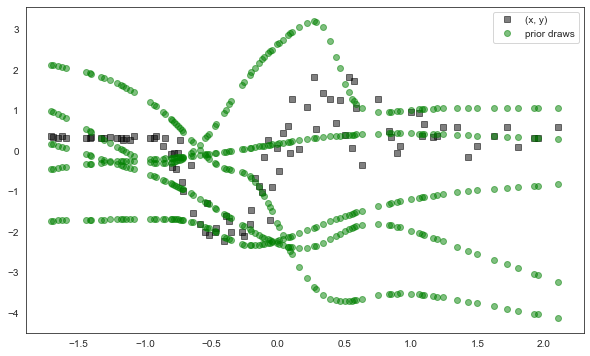

In [8]:
#checking prior draws

with neural_network:
    preds =[DNN(X_data, weights_in_1.random(), bias_in_1.random(), weights_1_2.random(), bias_1_2.random(), weights_2_out.random(), bias_2_out.random()).eval()
     for _ in range(5)]
    preds = np.asarray(preds)
    outputs = preds.reshape(preds.shape[0],preds.shape[1])
    print(np.shape(outputs))

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.plot(X_data, y_data, 'ks', alpha=0.5, label='(x, y)') # full data (train+test)
    ax.plot(X_data,outputs[0].T, 'go', alpha=0.5, label='prior draws')
    ax.plot(X_data,outputs[1:].T, 'go', alpha=0.5)
    ax.legend()
    plt.show()

In [9]:
from pymc3.theanof import set_tt_rng, MRG_RandomStreams
set_tt_rng(MRG_RandomStreams(42))

## Drawing samples

In [10]:
# Carrying out MCMC
with neural_network:
    trace = pm.sample(draws=5000, tune=1000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b_2_out, w_2_out, b_1_2, w_1_2, b_in_1, w_in_1]
Sampling 2 chains, 356 divergences: 100%|██████████| 12000/12000 [39:09<00:00,  5.11draws/s] 
There were 124 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 232 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or re

In [11]:
print(trace['w_in_1'].shape)

(10000, 1, 10)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"w_in_1[0,0]",-0.379,2.691,-4.795,4.160,0.328,0.233,67.0,67.0,83.0,336.0,1.02
"w_in_1[0,1]",0.249,2.702,-4.496,4.574,0.201,0.143,180.0,180.0,193.0,347.0,1.01
"w_in_1[0,2]",0.198,2.717,-4.312,4.785,0.271,0.192,100.0,100.0,109.0,405.0,1.01
"w_in_1[0,3]",0.059,2.698,-4.602,4.449,0.230,0.163,138.0,138.0,150.0,292.0,1.02
"w_in_1[0,4]",0.179,2.723,-4.861,4.254,0.210,0.148,169.0,169.0,183.0,401.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...
"w_2_out[6,0]",0.684,1.823,-2.827,3.122,0.225,0.160,66.0,66.0,71.0,195.0,1.02
"w_2_out[7,0]",-0.126,2.031,-3.073,3.004,0.481,0.346,18.0,18.0,24.0,440.0,1.08
"w_2_out[8,0]",0.750,1.724,-2.577,3.030,0.632,0.465,7.0,7.0,12.0,236.0,1.18
"w_2_out[9,0]",-0.511,1.716,-2.967,2.746,0.227,0.161,57.0,57.0,77.0,484.0,1.04


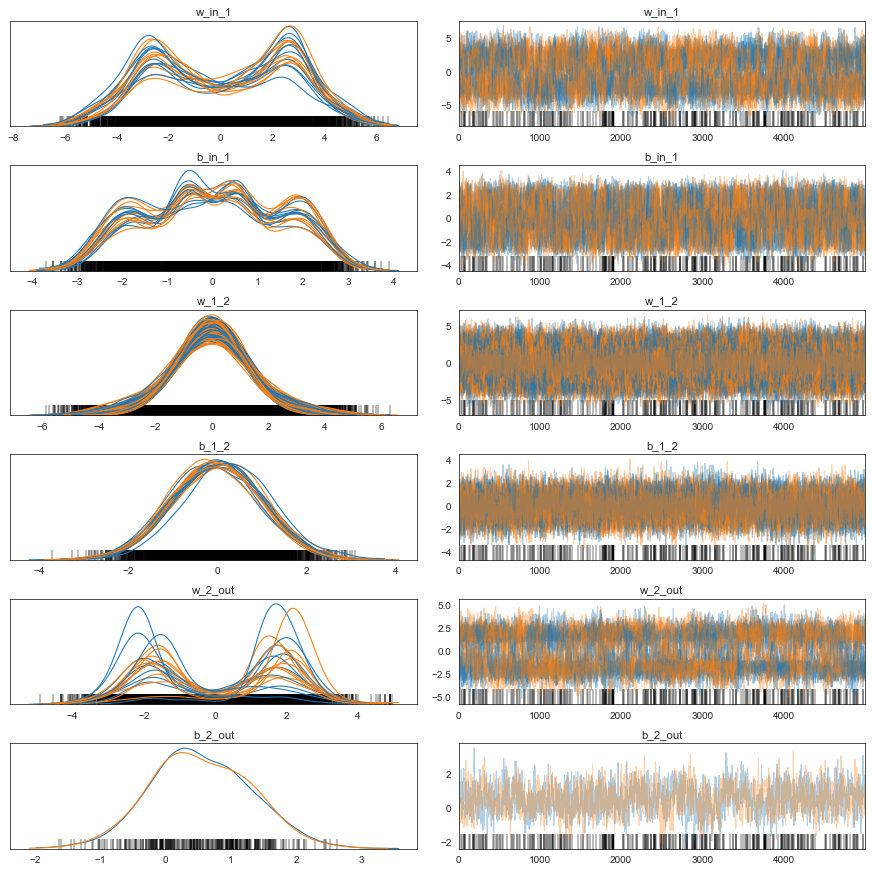

In [12]:
pm.traceplot(trace)
pm.summary(trace)

## Checking

(5, 94)


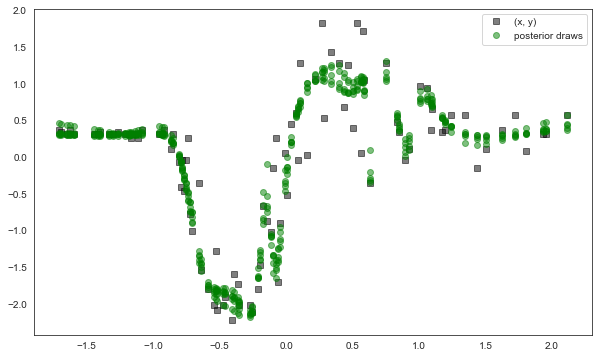

In [13]:
# checking posterior draws

preds =[DNN(X_data, trace['w_in_1'][i], trace['b_in_1'][i], trace['w_1_2'][i], trace['b_1_2'][i], trace['w_2_out'][i], trace['b_2_out'][i]).eval()
 for i in range(5)]
preds = np.asarray(preds)
outputs = preds.reshape(preds.shape[0],preds.shape[1])
print(np.shape(outputs))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(X_data,y_data, 'ks', alpha=0.5, label='(x, y)') # full data (train+test)
ax.plot(X_data,outputs[0].T, 'go', alpha=0.5, label='posterior draws')
ax.plot(X_data,outputs[1:].T, 'go', alpha=0.5)
ax.legend()
plt.show()

## Testing

In [14]:
# testing on whole data for now instead of test data
y_tensor.set_value(y_data)
x_tensor.set_value(X_data)

In [15]:
posterior_preds = pm.sample_posterior_predictive(trace, 1000, neural_network)

mean_prediction = np.mean(posterior_preds['out'], axis=0)
stddev_prediction = np.std(posterior_preds['out'], axis=0)
print (posterior_preds['out'].shape)

100%|██████████| 1000/1000 [00:16<00:00, 59.70it/s]

(1000, 94, 1)


        MCMC    actual  error_MCMC
0   1.085377  0.064198    1.021179
1   0.732156  0.658077    0.074079
2  -1.114193 -0.895294   -0.218899
3   0.917366  1.046904   -0.129538
4   1.043031  1.824556   -0.781525
..       ...       ...         ...
89 -1.873935 -2.007608    0.133673
90  0.254175  0.116429    0.137747
91  0.359171  0.321481    0.037689
92 -0.535528  0.269251   -0.804779
93 -1.471987  0.269251   -1.741238

[94 rows x 3 columns]


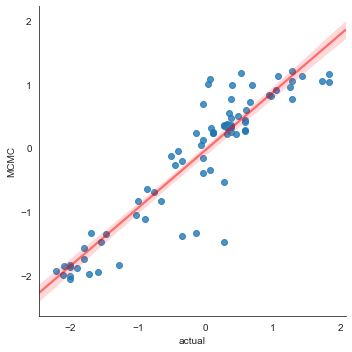

In [16]:
prediction_data = pd.DataFrame(
    {'MCMC': mean_prediction.flatten(), 
     'actual': y_data.flatten(),
     'error_MCMC': ( mean_prediction - y_data).flatten()})

print (prediction_data)

_ = sns.lmplot(y='MCMC', x='actual', data=prediction_data,
               line_kws={'color': 'red', 'alpha': 0.5})

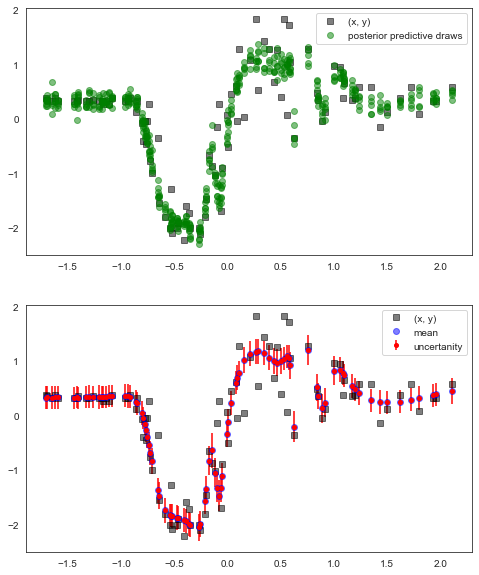

In [17]:
fig = plt.figure(figsize=(8, 10))

ax1 = fig.add_subplot(211)
ax1.plot(X_data, y_data, 'ks', alpha=0.5, label='(x, y)') # full data (train+test)
ax1.plot(X_data, posterior_preds['out'][0] ,'go', alpha=0.5, label='posterior predictive draws')
ax1.plot(X_data, posterior_preds['out'][1:5].reshape(4,X_data.shape[0]).T, 'go', alpha=0.5)
ax1.legend()

ax2 = fig.add_subplot(212)
ax2.plot(X_data, y_data, 'ks', alpha=0.5, label='(x, y)') # full data (train+test)
ax2.plot(X_data, mean_prediction , 'bo', alpha=0.5, label='mean')
# ax2.fill_between(X_data.ravel(), (mean_prediction-2*stddev_prediction).ravel(), (mean_prediction+2*stddev_prediction).ravel(), alpha = 0.3, color = 'orange',label='uncertanity')
ax2.errorbar(X_data, mean_prediction, yerr=1.96*stddev_prediction, fmt='o', label='uncertanity', color='red',markersize=4)
ax2.legend()

plt.show()

In [18]:
RMSE = np.sqrt(np.mean(prediction_data.error_MCMC ** 2))

print(f'RMSE for MCMC predictions = {RMSE:.3f}')

RMSE for MCMC predictions = 0.387


(10000, 1, 10)


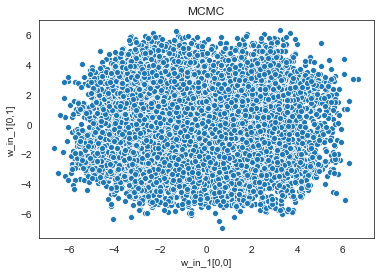

In [19]:
print(trace.get_values('w_in_1').shape)

param_samples_MCMC = pd.DataFrame(
    {'w_in_1[0,0]': trace.get_values('w_in_1').reshape(trace.get_values('w_in_1').shape[0],trace.get_values('w_in_1').shape[2])[:,0], 
     'w_in_1[0,1]': trace.get_values('w_in_1').reshape(trace.get_values('w_in_1').shape[0],trace.get_values('w_in_1').shape[2])[:,1]})

_ = sns.scatterplot(x='w_in_1[0,0]', y='w_in_1[0,1]', data=param_samples_MCMC).set_title('MCMC')

In [20]:
print (trace['w_in_1'].shape)

(10000, 1, 10)
